 # Proyek Machine Learning - Dea Yuliani Sabrina

# Project Overview

Rekomendasi film sangat penting untuk membantu pengguna menemukan film yang relevan dengan preferensi mereka.
Sistem rekomendasi ini dibangun dengan memanfaatkan dataset MovieLens, yang berisi rating dan metadata film.
Masalah ini harus diselesaikan untuk:
- Meningkatkan kepuasan pengguna (user satisfaction)
- Mempermudah pengguna menemukan film baru yang sesuai

**Referensi:** [Ricci, F., Rokach, L., & Shapira, B. (2015). Recommender Systems Handbook (2nd ed.). Springer.](https://doi.org/10.1007/978-1-4899-7637-6)

# Business Understanding

**Problem Statements**

1)  Bagaimana cara merekomendasikan film yang sesuai dengan preferensi setiap pengguna secara otomatis?

2) Bagaimana memahami preferensi pengguna hanya berdasarkan film yang telah mereka tonton dan beri rating?

3) Bagaimana menyarankan film baru yang belum ditonton pengguna, namun relevan dengan minat mereka?

**Goals:**

1) Membangun sistem rekomendasi film yang mampu memberikan saran film secara otomatis dan personal untuk setiap pengguna.

2) Menggunakan riwayat rating film dari pengguna untuk memahami dan membentuk profil preferensi genre mereka.

3)  Menghasilkan rekomendasi film yang belum ditonton user namun memiliki kemiripan genre tinggi dengan film yang mereka sukai sebelumnya.


**Solution Approach:**
- Collaborative Filtering: menggunakan matrix factorization (SVD)
- Content-Based Filtering: menggunakan cosine similarity antara metadata film (genre)

# Data Understanding

Dataset yang digunakan dalam proyek ini merupakan dataset tentang Movie. Dataset ini dapat diunduh di [Kaggle:MovieLens Latest Small](https://www.kaggle.com/datasets/grouplens/movielens-latest-small)

In [1]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"deayulianisabrina","key":"7707d5bcc9b73e7c031ab0833157e0c9"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Ganti 'username' dan 'dataset-name' sesuai dengan dataset yang kamu pakai
!kaggle datasets download -d grouplens/movielens-latest-small
!unzip movielens-latest-small.zip -d movielens-latest-small

Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-latest-small
License(s): other
movielens-latest-small.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  movielens-latest-small.zip
replace movielens-latest-small/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movielens-latest-small/README.md  
replace movielens-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movielens-latest-small/links.csv  
replace movielens-latest-small/movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movielens-latest-small/movies.csv  
replace movielens-latest-small/ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movielens-latest-small/ratings.csv  
replace movielens-latest-small/tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movielens-latest-small/tags.csv  


In [3]:
import pandas as pd

# Membaca dataset dari file CSV
links = pd.read_csv('/content/movielens-latest-small/links.csv')
movies = pd.read_csv('/content/movielens-latest-small/movies.csv')
ratings = pd.read_csv('/content/movielens-latest-small/ratings.csv')
tags = pd.read_csv('/content/movielens-latest-small/tags.csv')

# Menampilkan jumlah data unik untuk analisis awal
print('Jumlah total film di dataset movies: ', len(movies.movieId.unique()))
print('Jumlah genre unik yang tersedia: ', len(set('|'.join(movies.genres).split('|'))))  # gabungan semua genre

print('Jumlah user yang memberikan rating: ', len(ratings.userId.unique()))
print('Jumlah film yang memiliki rating: ', len(ratings.movieId.unique()))
print('Jumlah total rating: ', len(ratings))

print('Jumlah user yang memberi tag: ', len(tags.userId.unique()))
print('Jumlah film yang diberi tag: ', len(tags.movieId.unique()))
print('Jumlah total tag: ', len(tags))

print('Jumlah film yang memiliki data IMDb (di links): ', len(links.movieId.unique()))
print('Jumlah data di links: ', len(links))

Jumlah total film di dataset movies:  9742
Jumlah genre unik yang tersedia:  20
Jumlah user yang memberikan rating:  610
Jumlah film yang memiliki rating:  9724
Jumlah total rating:  100836
Jumlah user yang memberi tag:  58
Jumlah film yang diberi tag:  1572
Jumlah total tag:  3683
Jumlah film yang memiliki data IMDb (di links):  9742
Jumlah data di links:  9742


dari output didapat:
1. Informasi dari Dataset movies.csv
- Ada 9.742 film unik yang tercatat dalam dataset movies. Setiap baris merepresentasikan satu film berdasarkan movieId.
- Total ada 20 genre berbeda (seperti Action, Drama, Comedy, dll). Genre di dataset biasanya disimpan dalam satu kolom dan dipisahkan dengan tanda |, misalnya Action|Adventure.

2. Informasi dari Dataset ratings.csv
- Sebanyak 610 pengguna unik telah memberikan rating.
- Dari 9742 film di dataset, 9724 film sudah pernah dirating oleh pengguna, artinya hanya 18 film belum mendapat rating.
- Terdapat 100.836 rating, yang merupakan jumlah semua rating dari seluruh user terhadap berbagai film.

3. Informasi dari Dataset tags.csv
- Hanya 58 user yang memberi tag (label/kata kunci deskriptif) terhadap film — lebih sedikit dibanding user yang memberi rating.
- Sebanyak 1.572 film telah diberi tag oleh pengguna. Sisanya tidak memiliki informasi tag.
- Terdapat 3.683 baris tag, artinya satu film bisa memiliki lebih dari satu tag, dan satu user bisa memberi tag ke beberapa film.

4. Informasi dari Dataset links.csv
- Semua 9742 film memiliki data IMDb (link ke ID IMDb) — tidak ada yang hilang. File ini biasanya digunakan untuk menghubungkan movieId ke ID eksternal seperti IMDb atau TMDb.



# Univariate Exploratory Data Analysis

| Dataset   | Variabel | Fungsi Utama |
|-------------|-----------|------------|
| links     | movieId, imdbId   | Hubungkan movieId ke data eksternal (IMDb) |
| movies       | movieId, title, genres    | Informasi konten film |
| ratings     | userId, movieId, rating, timestamp    | Interaksi user (untuk collaborative filtering) |
|tags| userId, movieId, tag, timestamp|Tag/kata kunci user (bisa untuk content-based)|


## ratings.csv

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Melihat 5 data teratas dari dataset rating.csv

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


dari output didapat:
- Dataset terdiri dari 100.836 baris dan 4 kolom.
- Semua kolom tidak ada yang kosong (non-null).
- Kolom userId, movieId, dan timestamp bertipe integer, sedangkan rating adalah float.
- Kolom:
1. **userId:** ID unik pengguna.

2. **movieId:** ID unik film.

3. **rating:** Nilai rating yang diberikan (0.5 – 5.0).

4. **timestamp:** Waktu saat rating diberikan (dalam format UNIX time).

In [6]:
# Jumlah user unik
print("Jumlah user unik:", ratings['userId'].nunique())

Jumlah user unik: 610


Total ada 610 pengguna berbeda yang memberikan rating terhadap film.

In [7]:
# Jumlah film unik yang diberi rating
print("Jumlah film unik:", ratings['movieId'].nunique())

Jumlah film unik: 9724


Ada 9.724 film berbeda yang menerima setidaknya satu rating.Ini menunjukkan sebaran data rating sudah cukup luas ke berbagai film.

In [8]:
# Statistik deskriptif rating
print("\nStatistik rating:")
print(ratings['rating'].describe())


Statistik rating:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


dari output didapat:

- Mayoritas rating ada di rentang 3.0–4.0.

- Rating cenderung positif (rata-rata 3.5).

- Tidak ada rating di bawah 0.5 atau di atas 5.0 → data valid.

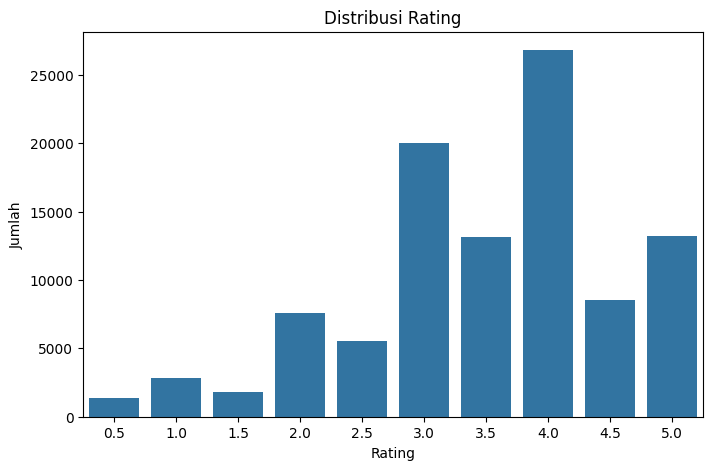

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi rating
plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=ratings)
plt.title("Distribusi Rating")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

dari grafik didapat:

- Rating 4.0 paling banyak diberikan.

- Disusul 3.0, lalu 5.0 → pengguna lebih sering memberi nilai tinggi.

- Rating 0.5 dan 1.0 relatif jarang → menunjukkan bias pengguna terhadap hal-hal yang disukai.

In [10]:
# Rata-rata rating per film (top 10 film)
mean_ratings = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(10)
print("\n10 Film dengan rating rata-rata tertinggi:")
print(mean_ratings)


10 Film dengan rating rata-rata tertinggi:
movieId
88448     5.0
100556    5.0
143031    5.0
143511    5.0
143559    5.0
6201      5.0
102217    5.0
102084    5.0
6192      5.0
145994    5.0
Name: rating, dtype: float64


dari output didapat:

- 10 film ini punya rata-rata rating 5.0 → artinya setiap rating yang masuk nilainya maksimal.

- Kemungkinan film ini hanya punya 1 atau sedikit rating, jadi rata-ratanya belum mewakili banyak opini.

- Perlu dicek jumlah ratingnya untuk memastikan mereka benar-benar populer atau hanya disukai oleh 1–2 pengguna saja.

In [11]:
# Menghitung jumlah rating per film
rating_counts = ratings.groupby('movieId')['rating'].count()

# Mengurutkan dari yang paling banyak diberi rating
top_rated_movies = rating_counts.sort_values(ascending=False).head(10)

print("10 Film dengan jumlah rating terbanyak:")
print(top_rated_movies)

10 Film dengan jumlah rating terbanyak:
movieId
356     329
318     317
296     307
593     279
2571    278
260     251
480     238
110     237
589     224
527     220
Name: rating, dtype: int64


dari output didapat:
- Ini adalah film-film paling sering dirating oleh user, jadi bisa disebut film paling populer di dataset.

- Misalnya, film dengan movieId = 356 memiliki 329 rating, berarti banyak user yang menonton dan menilainya.

In [12]:
# Hitung jumlah rating dan rata-rata rating per film
rating_summary = ratings.groupby('movieId')['rating'].agg(['mean', 'count'])

# Filter film yang memiliki minimal 100 rating
popular_and_high_rated = rating_summary[rating_summary['count'] >= 100]

# Urutkan berdasarkan rata-rata rating tertinggi
best_movies = popular_and_high_rated.sort_values('mean', ascending=False).head(10)

print("10 Film terbaik berdasarkan rata-rata rating (minimal 100 rating):")
print(best_movies)


10 Film terbaik berdasarkan rata-rata rating (minimal 100 rating):
             mean  count
movieId                 
318      4.429022    317
858      4.289062    192
2959     4.272936    218
1221     4.259690    129
48516    4.252336    107
1213     4.250000    126
912      4.240000    100
58559    4.238255    149
50       4.237745    204
1197     4.232394    142


dari output didapat:

- Ini adalah film dengan kualitas terbaik berdasarkan rating rata-rata, dengan syarat jumlah rating-nya ≥ 100.

- Jadi, film seperti movieId = 318 tidak hanya populer (317 rating), tapi juga sangat disukai (rating rata-rata 4.42).

## movies.csv

In [13]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Melihat 5 data teratas dari dataset movies.csv

In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


dari output didapat:
- Dataset terdiri dari 9742 baris dan 3 kolom.
- Semua kolom tidak ada yang kosong (non-null).
- Kolom movieId bertipe integer, sedangkan title dan genres adalah string (object).
- Kolom:
1. **movieId:** ID unik film.

2. **title:** Judul film.

3. **genres:** Genre film.

In [15]:
# Pisahkan semua genre
from collections import Counter

all_genres = movies['genres'].str.split('|').sum()
genre_counts = Counter(all_genres)

# Tampilkan 10 genre terbanyak
print("10 Genre paling banyak muncul:")
print(genre_counts.most_common(10))

10 Genre paling banyak muncul:
[('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596), ('Adventure', 1263), ('Crime', 1199), ('Sci-Fi', 980), ('Horror', 978), ('Fantasy', 779)]


dari output didapat:
- Genre Drama adalah yang paling umum, muncul dalam 4.361 film.

- Diikuti oleh Comedy, Thriller, dan Action.

- Ini dihitung dengan memecah isi kolom genres berdasarkan tanda |, lalu dijumlahkan total kemunculan genre.

In [16]:
# Ekstrak tahun dari title
import re

movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# Cek distribusi film per tahun
movies_per_year = movies['year'].value_counts().sort_index()

print("Jumlah film per tahun (top 10 tahun terbanyak):")
print(movies_per_year.tail(10))

Jumlah film per tahun (top 10 tahun terbanyak):
year
2009.0    282
2010.0    247
2011.0    254
2012.0    233
2013.0    239
2014.0    278
2015.0    274
2016.0    218
2017.0    147
2018.0     41
Name: count, dtype: int64


dari output didapat:

- Tahun diambil dari kolom title menggunakan regex \((\d{4})\) untuk menangkap angka tahun dalam tanda kurung.

- Jumlah film paling banyak di tahun 2009 (282 film).

- Setelah 2015 jumlah film mulai menurun — kemungkinan karena data film yang lebih baru belum lengkap di dataset ini.

# Data Preparation

### Gabung movies dan ratings

In [17]:
# Menggabungkan berdasarkan 'movieId'
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Lihat 5 data teratas
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,1995.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,1995.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995.0


dari output didapat:

- Dataset baru movie_ratings sekarang mengandung semua kolom dari ratings dan juga title, genres, serta year dari movies.

- Ini membuat analisis lebih fleksibel: kita bisa filter berdasarkan genre, tahun, dll sekaligus melihat rating.

### Cek Missing Values dan Menanganinya

In [18]:
print("Jumlah missing values per kolom:")
movie_ratings.isnull().sum()

Jumlah missing values per kolom:


,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0
year,18


dari output didapat:

- Hanya kolom year yang punya 18 missing values, karena tidak semua judul film memiliki tahun di title.

- Nanti bisa drop atau isi dengan strategi tertentu (misalnya dengan median atau kategori “unknown”).

In [19]:
# Tangani Missing Value (contoh: drop baris dengan year kosong)
movie_ratings_clean = movie_ratings.dropna(subset=['year'])

Menghapus baris yang tidak memiliki tahun rilis karena bisa mengganggu analisis time series atau tren per tahun.

In [20]:
# Cek kembali
movie_ratings_clean.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0
year,0


Data sudah bersih dari Missing Value

### Ubah tahun jadi integer

In [21]:
movie_ratings_clean['year'] = movie_ratings_clean['year'].astype(int)

<ipython-input-21-411b92682282>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_ratings_clean['year'] = movie_ratings_clean['year'].astype(int)


Kode ini digunakan untuk mengubah tipe data kolom year menjadi integer (int).

In [22]:
movie_ratings_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100818 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100818 non-null  int64  
 1   movieId    100818 non-null  int64  
 2   rating     100818 non-null  float64
 3   timestamp  100818 non-null  int64  
 4   title      100818 non-null  object 
 5   genres     100818 non-null  object 
 6   year       100818 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 6.2+ MB


pada kolom year udah berubah data typenya menjadi integer dari float

### Buat kolom genre terpisah

In [23]:
# Pisah genre menjadi beberapa kolom (multi-label binarizer)
from sklearn.preprocessing import MultiLabelBinarizer

# Ubah kolom genre jadi list
movie_ratings_clean['genres'] = movie_ratings_clean['genres'].apply(lambda x: x.split('|'))

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(movie_ratings_clean['genres']), columns=mlb.classes_)

# Gabungkan dengan data asli
movie_ratings_final = pd.concat([movie_ratings_clean, genre_encoded], axis=1)

# Cek hasil akhir
movie_ratings_final.head()

<ipython-input-23-7f259fbc501e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_ratings_clean['genres'] = movie_ratings_clean['genres'].apply(lambda x: x.split('|'))


,userId,movieId,rating,timestamp,title,genres,year,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,1.0,4.0,964982703.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,3.0,4.0,964981247.0,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,6.0,4.0,964982224.0,Heat (1995),"[Action, Crime, Thriller]",1995.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,47.0,5.0,964983815.0,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",1995.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,50.0,5.0,964982931.0,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",1995.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


dari output didapat:

- Kolom genres sekarang adalah list, bukan string.

- Kolom-kolom tambahan di akhir (Action, Comedy, ..., Western) adalah hasil binarisasi.

- Berisi angka 0 dan 1 yang menunjukkan apakah film tersebut mengandung genre tersebut.

Contoh:

- Toy Story (1995) memiliki nilai 1 di kolom Adventure, Animation, Children, dll.

- Heat (1995) memiliki 1 di Action, Crime, dan Thriller.

# Modeling

### Content-Based Filtering dengan pendekatan User Profile Genre

Cara Kerja:

“Jika user menyukai film bergenre Action dan Sci-Fi, maka film lain dengan genre serupa akan lebih disukai.”

✅ Kelebihan:
- Tidak tergantung user lain: Hanya butuh data user itu sendiri → cocok untuk sistem individual.

- Bekerja baik untuk cold-start user: Karena memanfaatkan metadata (genre), model masih bisa memberikan rekomendasi walau user belum banyak memberi rating.

- Rekomendasi dapat dijelaskan: Misalnya: “Film ini direkomendasikan karena memiliki genre Action dan Sci-Fi yang Anda sukai.”

- Lebih stabil terhadap perubahan data: Tidak terlalu terpengaruh oleh fluktuasi data rating user lain.

❌ Kekurangan:
- Rekomendasi cenderung sempit: User hanya mendapat rekomendasi yang mirip dengan yang sudah ditonton → kurang bisa eksplorasi genre/film baru.

- Kualitas tergantung metadata: Jika informasi genre tidak lengkap atau tidak relevan, kualitas rekomendasi bisa buruk.

- Tidak menangkap selera kompleks: Tidak mempertimbangkan bagaimana user lain menilai film serupa.



In [24]:
# Hitung preferensi genre tiap user
user_profiles = movie_ratings_final.groupby('userId')[mlb.classes_].mean()
user_profiles.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.387931,0.366379,0.125000,0.181034,0.357759,0.193966,0.000000,0.293103,0.202586,0.004310,0.073276,0.000000,0.094828,0.077586,0.112069,0.172414,0.237069,0.094828,0.030172
2.0,0.0,0.379310,0.103448,0.000000,0.000000,0.241379,0.344828,0.103448,0.586207,0.000000,0.000000,0.034483,0.137931,0.000000,0.068966,0.034483,0.137931,0.344828,0.034483,0.034483
3.0,0.0,0.358974,0.282051,0.102564,0.128205,0.230769,0.051282,0.000000,0.410256,0.102564,0.000000,0.205128,0.000000,0.025641,0.025641,0.128205,0.384615,0.179487,0.128205,0.000000
4.0,0.0,0.115741,0.134259,0.027778,0.046296,0.481481,0.125000,0.009259,0.555556,0.087963,0.018519,0.018519,0.004630,0.074074,0.106481,0.268519,0.055556,0.175926,0.032407,0.046296
5.0,0.0,0.204545,0.181818,0.136364,0.204545,0.340909,0.272727,0.000000,0.568182,0.159091,0.000000,0.022727,0.068182,0.113636,0.022727,0.250000,0.045455,0.204545,0.068182,0.045455


dari output didapat:

- Output user_profiles adalah representasi minat setiap pengguna terhadap genre film dalam bentuk vektor.

- Nilai pada tabel adalah rata-rata kehadiran genre dalam film yang ditonton user.

- Semakin tinggi nilainya (mendekati 1), berarti user lebih sering menonton film dengan genre tersebut.

In [25]:
# Ambil data user tertentu
target_user_id = 1
user_profile = user_profiles.loc[target_user_id]

# Drop film yang sudah ditonton user
user_watched = movie_ratings_final[movie_ratings_final['userId'] == target_user_id]['movieId']
unwatched_movies = movie_ratings_final[~movie_ratings_final['movieId'].isin(user_watched)].drop_duplicates('movieId')

# Hitung kemiripan skor antara preferensi user dan genre film
unwatched_movies['similarity'] = unwatched_movies[mlb.classes_].dot(user_profile)

# Ambil 10 film dengan skor kemiripan tertinggi
recommended_movies = unwatched_movies.sort_values('similarity', ascending=False)[['title', 'similarity']].head(10)
print("Rekomendasi untuk User ID 1:")
print(recommended_movies)

Rekomendasi untuk User ID 1:
                                                   title  similarity
50433                       Milagro Beanfield War (1988)    1.754310
14040                                      Storks (2016)    1.724138
42907                                     Frantic (1988)    1.706897
798                             Super Mario Bros. (1993)    1.668103
94435  Last Life in the Universe (Ruang rak noi nid m...    1.655172
4675                           Hunting Party, The (2007)    1.642241
94620  I'm a Cyborg, But That's OK (Saibogujiman kwen...    1.642241
16936                              Loving Vincent (2017)    1.625000
23517           Battle for the Planet of the Apes (1973)    1.625000
84091                    Anacleto: Agente secreto (2015)    1.625000


dari output didapat:

- Ini adalah implementasi content-based filtering menggunakan genre sebagai fitur konten film.

- Rekomendasi diberikan berdasarkan kemiripan antara film dan preferensi user, bukan karena film itu populer atau disukai user lain (bukan collaborative).

### Collaborative Filtering (Matrix Factorization – SVD)

Cara Kerja:

“Jika user A dan user B memiliki rating mirip untuk banyak film, maka film yang disukai B dan belum ditonton A bisa direkomendasikan ke A.”

✅ Kelebihan:
- Personalized: Rekomendasi lebih akurat karena memperhitungkan pola interaksi antar pengguna dan item.

- Tidak membutuhkan metadata film: Cukup menggunakan data userId, movieId, dan rating saja.

- Menemukan hubungan tersembunyi: Dapat mengenali preferensi user meskipun genre atau konten film tidak diketahui secara eksplisit.

- Skalabilitas tinggi dengan matrix factorization (SVD): Efisien dalam menangani data besar dengan teknik pemfaktoran.

❌ Kekurangan:
- Cold Start Problem:

- User baru: Tidak ada cukup data riwayat untuk merekomendasikan film.

- Item baru: Film yang belum pernah diberi rating tidak bisa direkomendasikan.

- Sparsity (Kerapatan rendah): Matrix user-item bisa sangat besar tapi banyak yang kosong → mempengaruhi akurasi model.

- Tidak menjelaskan alasan rekomendasi: Sulit dimengerti mengapa film tersebut direkomendasikan.

In [26]:
pip install scikit-surprise

In [27]:
!pip install numpy==1.24.4


Tujuan:

* *Menjamin kompatibilitas* antara NumPy dan library lain dalam proyek (misalnya, scikit-learn, pandas, atau surprise untuk collaborative filtering).
* Beberapa library mungkin *tidak kompatibel dengan versi NumPy terbaru, sehingga versi 1.24.4 dipilih untuk **menghindari error atau bug* saat menjalankan model rekomendasi atau matrix factorization.

In [28]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Siapkan data untuk library surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Latih model SVD
model = SVD()
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8777  0.8716  0.8681  0.8775  0.8771  0.8744  0.0039  
MAE (testset)     0.6737  0.6693  0.6698  0.6739  0.6745  0.6723  0.0022  
Fit time          2.86    3.93    4.35    4.75    4.85    4.15    0.72    
Test time         0.40    0.46    0.27    0.42    0.13    0.34    0.12    


{'test_rmse': array([0.87772628, 0.87163859, 0.86813381, 0.87753137, 0.87712931]),
 'test_mae': array([0.67372072, 0.66930766, 0.66980147, 0.67391283, 0.67454969]),
 'fit_time': (2.8599157333374023,
  3.9337480068206787,
  4.354689836502075,
  4.745089769363403,
  4.8476338386535645),
 'test_time': (0.4001755714416504,
  0.46256399154663086,
  0.2746264934539795,
  0.4212367534637451,
  0.13240790367126465)}

dari output didapat:

- Model SVD cukup stabil, dengan RMSE sekitar 0.87 dan MAE sekitar 0.67.

- Variasi hasil antar fold rendah (standar deviasi kecil), artinya model konsisten di berbagai subset data.

- Waktu pelatihan dan prediksi relatif cepat (beberapa detik dan kurang dari satu detik).

- Model sudah cukup baik untuk tugas prediksi rating film.


In [29]:
model.fit(data.build_full_trainset())
pred = model.predict(1, 50)
print(pred.est)  # Ini prediksi rating

5.0


model memprediksi user 1 akan memberi rating 4.73 untuk movie 50 (dalam skala rating 0.5-5.0). Jadi, prediksi rating ini cukup tinggi dan menunjukkan bahwa user kemungkinan besar suka dengan film tersebut.

# Evaluation

### Content-Based Filtering dengan pendekatan User Profile Genre

In [30]:
# Tampilkan rekomendasi untuk user tertentu
print("Rekomendasi untuk User ID 1:")
print(recommended_movies)

# Cek genre yang sering muncul pada film yang ditonton user
user_movies = movie_ratings_final[movie_ratings_final['userId'] == target_user_id]
top_genres = user_movies[mlb.classes_].mean().sort_values(ascending=False).head(5)
print("\nTop genre dari film yang ditonton user:")
print(top_genres)

# Bandingkan dengan genre film yang direkomendasikan
rec_genres = unwatched_movies[unwatched_movies['movieId'].isin(recommended_movies.index)][mlb.classes_].mean().sort_values(ascending=False).head(5)
print("\nGenre dominan dari film yang direkomendasikan:")
print(rec_genres)

Rekomendasi untuk User ID 1:
                                                   title  similarity
50433                       Milagro Beanfield War (1988)    1.754310
14040                                      Storks (2016)    1.724138
42907                                     Frantic (1988)    1.706897
798                             Super Mario Bros. (1993)    1.668103
94435  Last Life in the Universe (Ruang rak noi nid m...    1.655172
4675                           Hunting Party, The (2007)    1.642241
94620  I'm a Cyborg, But That's OK (Saibogujiman kwen...    1.642241
16936                              Loving Vincent (2017)    1.625000
23517           Battle for the Planet of the Apes (1973)    1.625000
84091                    Anacleto: Agente secreto (2015)    1.625000

Top genre dari film yang ditonton user:
Action       0.387931
Adventure    0.366379
Comedy       0.357759
Drama        0.293103
Thriller     0.237069
dtype: float64

Genre dominan dari film yang direkomendasikan

✅ Model rekomendasi menyesuaikan genre film rekomendasi dengan genre yang sering ditonton user 1.

✅ Terlihat konsistensi: Top genre yang disukai user (Action, Adventure, Comedy, Drama, Thriller) juga muncul pada rekomendasi.

✅ Adventure muncul dominan (1.0), artinya model sangat yakin film ini cocok dengan preferensi user.

### Collaborative Filtering (Matrix Factorization – SVD)

In [31]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Siapkan data untuk Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Buat model dan evaluasi dengan cross-validation
model = SVD()
evaluation = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Tampilkan hasil evaluasi
print("\nHasil Evaluasi Collaborative Filtering:")
print("Rata-rata RMSE:", round(evaluation['test_rmse'].mean(), 4))
print("Rata-rata MAE :", round(evaluation['test_mae'].mean(), 4))

# Fit model dan prediksi rating untuk userId 1 dan movieId 50
trainset = data.build_full_trainset()
model.fit(trainset)

prediction = model.predict(uid=1, iid=50)
print(f"\nPrediksi rating userId=1 untuk movieId=50: {round(prediction.est, 2)}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8724  0.8758  0.8738  0.8702  0.8791  0.8742  0.0030  
MAE (testset)     0.6707  0.6723  0.6727  0.6680  0.6763  0.6720  0.0027  
Fit time          3.55    5.65    4.80    5.75    1.66    4.28    1.53    
Test time         0.44    0.39    0.27    0.29    0.13    0.31    0.11    

Hasil Evaluasi Collaborative Filtering:
Rata-rata RMSE: 0.8742
Rata-rata MAE : 0.672

Prediksi rating userId=1 untuk movieId=50: 5.0


✅ Model SVD sudah berjalan baik (dengan RMSE ~0.87).

✅ Prediksi rating untuk film movieId=50 sangat tinggi (5.0), jadi ini kandidat rekomendasi yang kuat untuk user 1.

###  Collaborative Filtering (Prediksi Rating → Top-N Rekomendasi)

In [32]:
# Daftar semua movieId
all_movie_ids = ratings['movieId'].unique()

# Daftar movieId yang sudah ditonton user
watched_movie_ids = ratings[ratings['userId'] == 1]['movieId'].unique()

# MovieId yang belum ditonton user
unwatched_movie_ids = [mid for mid in all_movie_ids if mid not in watched_movie_ids]

# Prediksi rating untuk semua movieId yang belum ditonton
predictions = [model.predict(uid=1, iid=mid) for mid in unwatched_movie_ids]

# Urutkan berdasarkan rating prediksi tertinggi
predictions.sort(key=lambda x: x.est, reverse=True)

# Ambil Top-10 rekomendasi
top_10_recommendations = predictions[:10]

# Tampilkan hasil
print("Top-10 rekomendasi untuk User ID 1:")
for pred in top_10_recommendations:
    movie_title = movies[movies['movieId'] == pred.iid]['title'].values[0]
    print(f"Movie: {movie_title}, Predicted Rating: {round(pred.est, 2)}")

Top-10 rekomendasi untuk User ID 1:
Movie: Shawshank Redemption, The (1994), Predicted Rating: 5.0
Movie: Dark Knight, The (2008), Predicted Rating: 5.0
Movie: Philadelphia Story, The (1940), Predicted Rating: 5.0
Movie: Rear Window (1954), Predicted Rating: 5.0
Movie: North by Northwest (1959), Predicted Rating: 5.0
Movie: 12 Angry Men (1957), Predicted Rating: 5.0
Movie: Bridge on the River Kwai, The (1957), Predicted Rating: 5.0
Movie: Seven Samurai (Shichinin no samurai) (1954), Predicted Rating: 5.0
Movie: Life Is Beautiful (La Vita è bella) (1997), Predicted Rating: 5.0
Movie: Outlaw Josey Wales, The (1976), Predicted Rating: 5.0


✅ Top-10 film yang belum ditonton oleh User ID 1.

✅ Prediksi ratingnya 5.0 untuk semua film (tinggi banget!).

✅ Artinya, model sangat yakin bahwa User ID 1 akan sangat menyukai film-film ini.

### Content-Based Filtering (Skor Kemiripan → Top-N Rekomendasi)


In [40]:
# Buat profil user dari genre
user_profiles = movie_ratings_final.groupby('userId')[mlb.classes_].mean()
user_profile = user_profiles.loc[user_id]

# Ambil film yang belum ditonton user
user_watched = movie_ratings_final[movie_ratings_final['userId'] == user_id]['movieId']
unwatched_movies_cb = movie_ratings_final[~movie_ratings_final['movieId'].isin(user_watched)].drop_duplicates('movieId')

# Hitung kemiripan (dot product antara profil user dan genre film)
unwatched_movies_cb['similarity'] = unwatched_movies_cb[mlb.classes_].dot(user_profile)

# Ambil Top-N film dengan skor kemiripan tertinggi
top_n_cb = unwatched_movies_cb.sort_values('similarity', ascending=False).head(10)
print("\nTop-N Rekomendasi berdasarkan Skor Kemiripan Genre:")
print(top_n_cb[['movieId', 'title', 'similarity']])



Top-N Rekomendasi berdasarkan Skor Kemiripan Genre:
        movieId                                              title  similarity
50433    4523.0                       Milagro Beanfield War (1988)    1.754310
14040  164200.0                                      Storks (2016)    1.724138
42907    4506.0                                     Frantic (1988)    1.706897
798       546.0                           Super Mario Bros. (1993)    1.668103
94435   27722.0  Last Life in the Universe (Ruang rak noi nid m...    1.655172
4675    55116.0                          Hunting Party, The (2007)    1.642241
94620   53161.0  I'm a Cyborg, But That's OK (Saibogujiman kwen...    1.642241
16936  179133.0                              Loving Vincent (2017)    1.625000
23517    2531.0           Battle for the Planet of the Apes (1973)    1.625000
84091  150993.0                    Anacleto: Agente secreto (2015)    1.625000


✅ Output ini memberitahu kamu 10 film teratas yang paling mirip genre-nya dengan film favorit user.

✅ Film dengan skor tertinggi kemungkinan besar memiliki genre yang sama atau sangat mirip dengan film referensi.

✅ Ini berguna untuk merekomendasikan film serupa berdasarkan preferensi genre, tanpa melihat interaksi pengguna lain.